In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import geopandas as gpd
from shapely.geometry import LineString

In [2]:
dtypes = {'ID': str, 
          'Device ID': str, 
          'Vehicle Type': 'category', 
          'Trip Duration': float, 
          'Trip Distance': float, 
          'Census Tract Start': str, 
          'Census Tract End': str}


# Create the dataframe.
scooters = pd.read_csv('./data/scooters.csv', dtype=dtypes)

C:\Users\ziyuf\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
scooters['Start Time'] = pd.to_datetime(scooters['Start Time'])
scooters['End Time'] = pd.to_datetime(scooters['End Time'])
scooters['Start Time (US/Central)'] = pd.to_datetime(scooters['Start Time (US/Central)'], format='%m/%d/%Y %I:%M:%S %p')
scooters['End Time (US/Central)'] = pd.to_datetime(scooters['End Time (US/Central)'], format='%m/%d/%Y %I:%M:%S %p')
scooters['Modified Date'] = pd.to_datetime(scooters['Modified Date'])


scooters['Day of Week'] = scooters['Day of Week'].astype('int8')
scooters['Month'] = scooters['Month'].astype('int8')
scooters['Hour'] = scooters['Start Time (US/Central)'].dt.hour.astype('int8')
scooters['Year'] = scooters['Year'].astype('int16')

scooters.dtypes

Device ID                           object
Vehicle Type                      category
Trip Duration                      float64
Trip Distance                      float64
Start Time                  datetime64[ns]
End Time                    datetime64[ns]
Modified Date               datetime64[ns]
Month                                 int8
Hour                                  int8
Day of Week                           int8
Council District (Start)            object
Council District (End)              object
Year                                 int16
Census Tract Start                  object
Census Tract End                    object
Start Time (US/Central)     datetime64[ns]
End Time (US/Central)       datetime64[ns]
dtype: object

## 2. How long (time or distance) are scooters used?

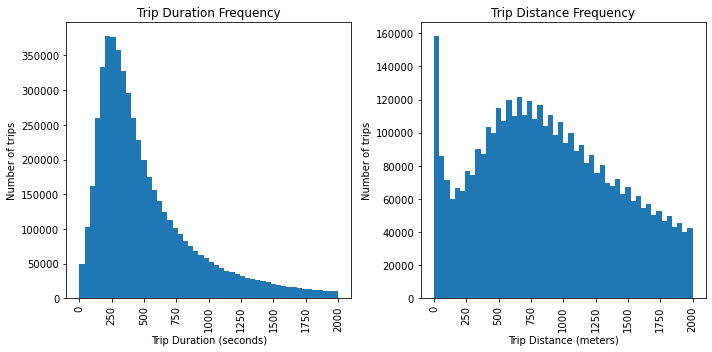

In [4]:
# Plot the histograms from above, with limits on the range
plt.figure(figsize=[10, 5])
plt.subplot(1,2,1)
plt.hist(scooters['Trip Duration'], bins=50, range=(0,2000))
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Number of trips')
plt.title('Trip Duration Frequency')
plt.xticks(rotation='vertical')

plt.subplot(1,2,2)
plt.hist(scooters['Trip Distance'], bins=50, range=(0, 2000))
plt.xlabel('Trip Distance (meters)')
plt.ylabel('Number of trips')
plt.title('Trip Distance Frequency')
plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()
plt.close()

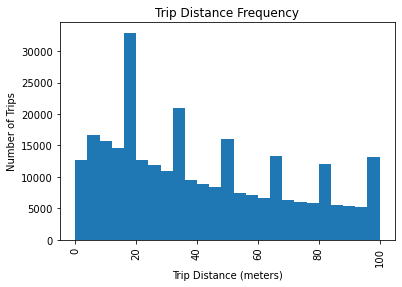

In [5]:
# Plot the 0-50 meters to see if there are any trends within the peak
plt.hist(scooters['Trip Distance'], bins=25, range=(0, 100))
plt.xlabel('Trip Distance (meters)')
plt.ylabel('Number of Trips')
plt.title('Trip Distance Frequency')
plt.xticks(rotation='vertical')

plt.show()
plt.close()

## 3. How many Census Tracts are in the data?
This project will use census tracts as a component of the predicted result (i.e. How many scooters should be placed in a certain location at a certain point in time?).  It will be helpful to understand how many unique census tracts exist.

In [6]:
# Use sets to find unique values for each
print('Number of Census Tract Starts: ' + str(len(set(scooters['Census Tract Start']))))
print('Number of Census Tract Ends: ' + str(len(set(scooters['Census Tract End']))))

# Save the unique set of census tracts as a CSV. This will be modified in step 11.
unique_cts = pd.DataFrame(set(scooters['Census Tract End'].append(scooters['Census Tract Start'])))
# unique_cts.to_csv('unique_census_tracts.csv')

# Print number of unique CTs
print('Number of unique Census Tracts in the data: ' + str(len(unique_cts)))

Number of Census Tract Starts: 269
Number of Census Tract Ends: 248
Number of unique Census Tracts in the data: 275


## 4. Which census tracts have the most traffic?

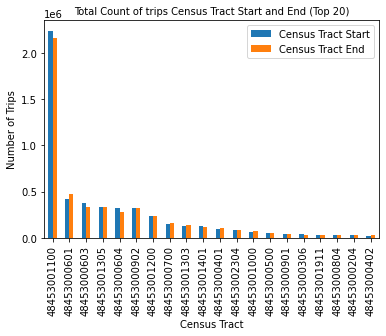

In [7]:
# Count how many trips started in each census tract
census_starts = pd.DataFrame(scooters['Census Tract Start'].value_counts())

# Count how many trips ended in each census tract
census_ends = pd.DataFrame(scooters['Census Tract End'].value_counts())

# Join start and end counts and plot the top 20. Value counts sorts descending, inner join preserves census start's sorting.
census_comp = census_starts.join(census_ends, how='inner')
census_comp.head(20).plot(kind='bar')
plt.title('Total Count of trips Census Tract Start and End (Top 20)', size = 10)
plt.xlabel('Census Tract')
plt.ylabel('Number of Trips')

plt.show()
plt.close()

C:\Users\ziyuf\AppData\Local\Temp/ipykernel_9620/1255947554.py:25: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['TRACTCE00'], xy=(row['INTPTLON00'], row['INTPTLAT00']), horizontalalignment='center',


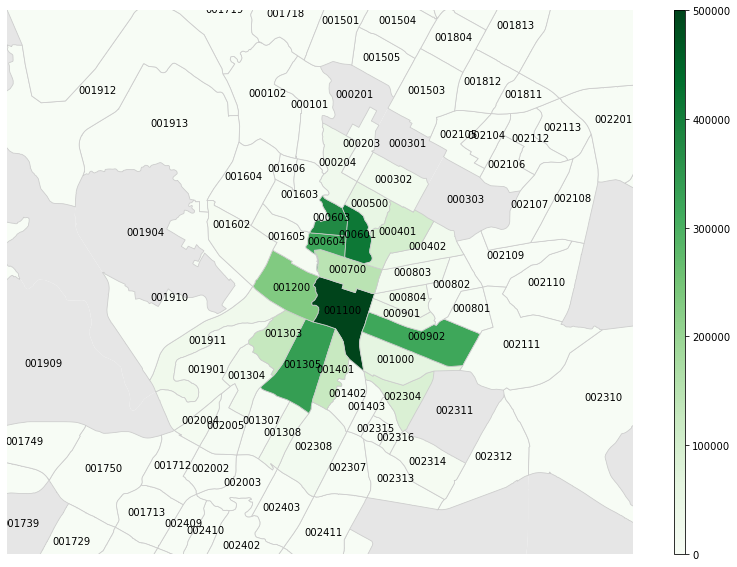

In [8]:
# Plot the census tracts from the US Census Bureau's shapefile using geopandas.
map_df = gpd.read_file('ct data/tl_2010_48453_tract00/tl_2010_48453_tract00.shp')

# Convert the lat/long of the centroids to floats
map_df['INTPTLAT00'] = map_df['INTPTLAT00'].astype('float64')
map_df['INTPTLON00'] = map_df['INTPTLON00'].astype('float64')

## Create a chloropleth of census tract starts
# Plot the data retrieved in the map
ax_start = map_df.plot(color='0.9', figsize=(15, 10))

# Merge the geodataframe with the census starts dataframe
starts_plot = map_df.set_index('CTIDFP00').join(census_starts, how='inner')

# Create a min and max for color
vmax_start = 500000
vmin_start = 0

# Overlay the census tract shapes as a chloropleth
starts_plot.plot(column='Census Tract Start', cmap='Greens', linewidth=0.8, ax=ax_start, edgecolor='0.8', 
                 vmax=vmax_start, vmin=vmin_start)

# Label the census tracts
for idx, row in map_df.iterrows():
    plt.annotate(s=row['TRACTCE00'], xy=(row['INTPTLON00'], row['INTPTLAT00']), horizontalalignment='center', 
                 clip_on=True)


# Set the limits of the plot
bbox = (-97.85, -97.65, 30.2,30.35)
plt.xlim(bbox[0], bbox[1])
plt.ylim(bbox[2], bbox[3])

# Remove the axis, add title, and legend
plt.axis('off')
# plt.title('Number of trips starting in each census tract')
sm_start = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin_start, vmax=vmax_start))
plt.colorbar(sm_start, fraction=0.015, aspect=50)

plt.show()
plt.close()


C:\Users\ziyuf\AppData\Local\Temp/ipykernel_9620/1468433687.py:18: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['TRACTCE00'], xy=(row['INTPTLON00'], row['INTPTLAT00']), horizontalalignment='center',


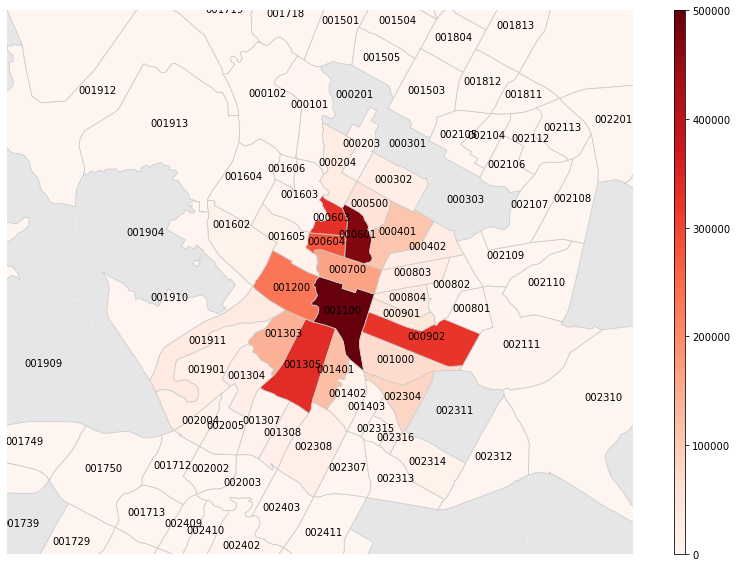

In [9]:
## Create a chloropleth of census tract ends
# Plot the data retrieved in the map
ax_start = map_df.plot(color='0.9', figsize=(15, 10))

# Merge the geodataframe with the census ends dataframe
ends_plot = map_df.set_index('CTIDFP00').join(census_ends, how='inner')

# Create a min and max for color
vmax_end = 500000
vmin_end = 0

# Overlay the census tract shapes as a chloropleth
ends_plot.plot(column='Census Tract End', cmap='Reds', linewidth=0.8, ax=ax_start, edgecolor='0.8', 
                 vmax=vmax_end, vmin=vmin_end)

# Label the census tracts
for idx, row in map_df.iterrows():
    plt.annotate(s=row['TRACTCE00'], xy=(row['INTPTLON00'], row['INTPTLAT00']), horizontalalignment='center', 
                 clip_on=True)


# Set the limits of the plot using bbox from above
plt.xlim(bbox[0], bbox[1])
plt.ylim(bbox[2], bbox[3])

# Remove the axis, add title, and legend
plt.axis('off')
# plt.title('Number of trips ending in each ')
sm_end = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin_end, vmax=vmax_end))
plt.colorbar(sm_end, fraction=0.015, aspect=50)

plt.show()
plt.close()

## 5. Which days have the most traffic?

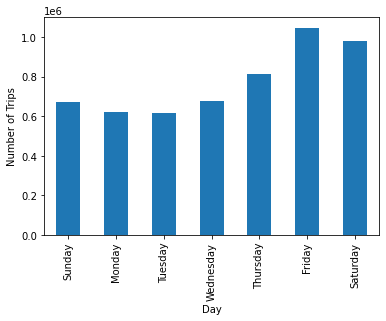

In [10]:
# Count trips per day and sort by day:
daily_total = pd.DataFrame(scooters['Day of Week'].value_counts().sort_index())

# Map day of week for better labels. Data documentation indicates "0=Sunday and so on.""
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
daily_total['Day'] = days

# Plot
daily_total.plot(kind='bar', x='Day', y='Day of Week', title='Total Trip Counts by Day of week', legend=False)
plt.ylabel('Number of Trips')
plt.show()
plt.close()

## 6. Does location affect day of week traffic differently?

To determine if different location have a different ridership pattern, we start with the top 4 census tract locations.

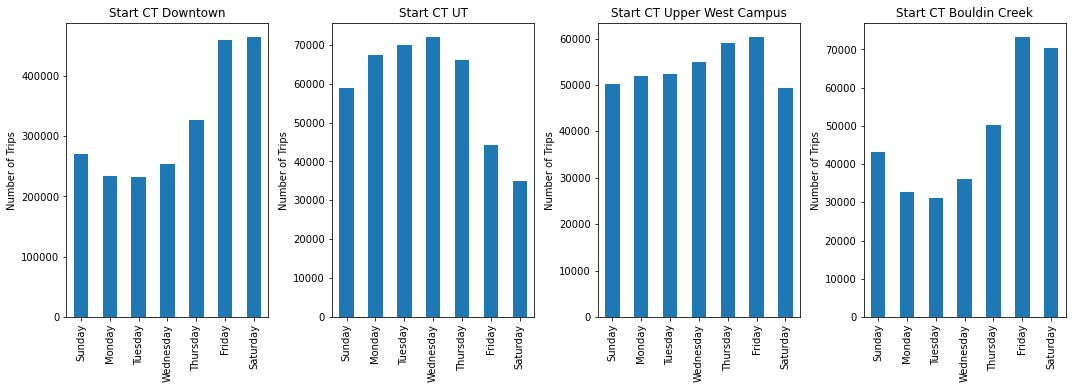

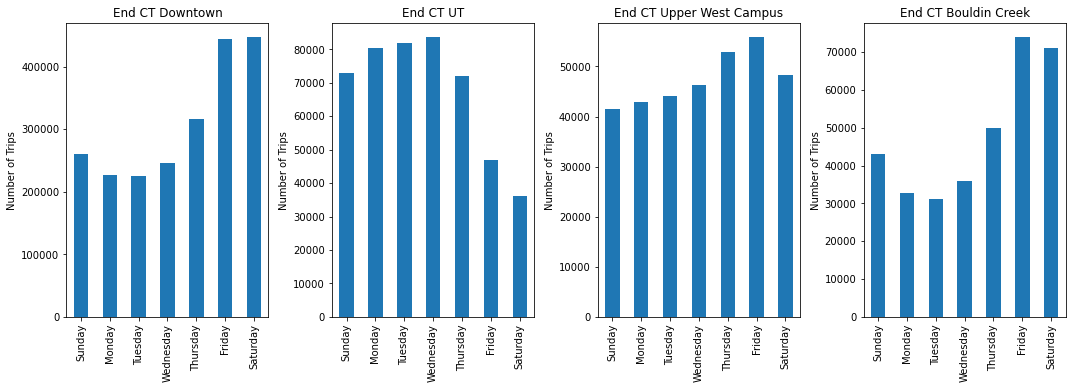

In [11]:
# Count start location by day:
weekday_start = scooters.groupby(by=['Day of Week', 'Census Tract Start']).count()
weekday_start_pivot = pd.pivot_table(weekday_start, index='Census Tract Start', values='Device ID', columns='Day of Week')

# Count end location by day:
weekday_end = scooters.groupby(by=['Day of Week', 'Census Tract End']).count()
weekday_end_pivot = pd.pivot_table(weekday_end, index='Census Tract End', values='Device ID', columns='Day of Week')

def plot_top_locations_by_day(pivot_table, ct_ids, title_prefix):
    plt.figure(figsize=[15, 5*len(ct_ids)])
    i = 1
    for ct_id in ct_ids:
        ct_pivot = pivot_table.loc[ct_id]
        #ct_pivot_sorted = ct_pivot.sum().sort_values(ascending=False)[:4]
        plt.subplot(len(ct_ids), 4, i)
        ct_pivot.plot(kind='bar')
        plt.xticks([0, 1, 2, 3, 4, 5, 6], days)
        plt.gca().set_xlabel('')
        
        if ct_id == '48453001100':
            location = 'Downtown'
        elif ct_id == '48453000601':
            location = 'UT'
        elif ct_id == '48453000603':
            location = 'Upper West Campus'
        elif ct_id == '48453001305':
            location = 'Bouldin Creek'
        
        plt.title(f'{title_prefix} {location}')
        plt.ylabel('Number of Trips')
        i += 1
    plt.tight_layout()
    plt.show()
    plt.close()

plot_top_locations_by_day(weekday_start_pivot, ['48453001100', '48453000601', '48453000603', '48453001305'], 'Start CT')
plot_top_locations_by_day(weekday_end_pivot, ['48453001100', '48453000601', '48453000603', '48453001305'], 'End CT')

## 7. How many trips start and end in different Census Tracts?

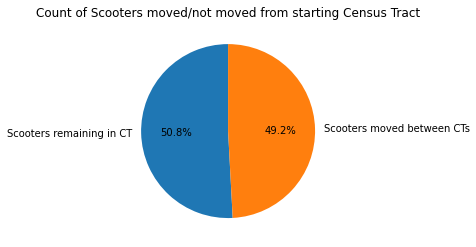

In [12]:
# Find entries where Census Tract Start and End are not equal
moved_scooters = scooters[scooters['Census Tract Start'] != scooters['Census Tract End']]
moved = moved_scooters.shape[0]

# Find entries where Census Tract Start and End are equal
stationary_scooters = scooters[scooters['Census Tract Start'] == scooters['Census Tract End']]
stationary = stationary_scooters.shape[0]

labels = ['Scooters remaining in CT', 'Scooters moved between CTs']
sizes = [moved, stationary]

# Create pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Count of Scooters moved/not moved from starting Census Tract')
plt.show()

## 8. Are certain months more popular than others?

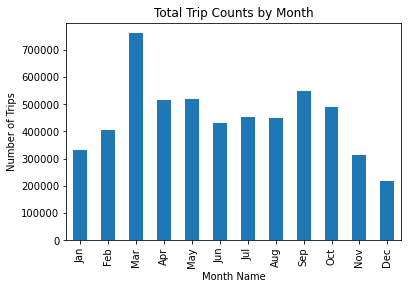

In [13]:
# Count trips per day and sort by day:
monthly_total = pd.DataFrame(scooters['Month'].value_counts().sort_index())

# Map month names for better labels.
monthly_total['Month Name'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot
monthly_total.plot(kind='bar', x='Month Name', y='Month', title='Total Trip Counts by Month', legend=False)
plt.ylabel('Number of Trips')
plt.show()
plt.close()

## 9. How has ridership changed over time?

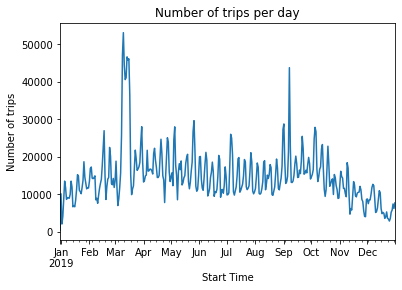

In [14]:
# Aggregate counts by day
scoots_per_day = scooters.resample('D', on='Start Time').count()

# Plot results (once again, arbitrarily using Device ID because using the count method)
scoots_per_day['Device ID'].plot()
plt.title('Number of trips per day')
plt.ylabel('Number of trips')
plt.show()
plt.close()


## 10. How does time of day affect ridership?

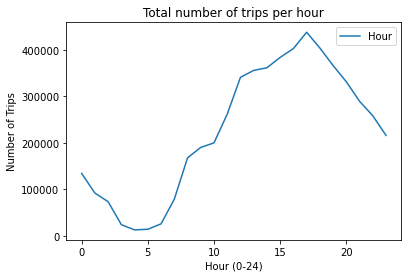

In [15]:
# Aggregate total counts by hour
scoots_per_hour = pd.DataFrame(scooters['Hour'].value_counts().sort_index())

# Plot results (once again, arbitrarily using Device ID)
scoots_per_hour.plot()
plt.title('Total number of trips per hour')
plt.xlabel('Hour (0-24)')
plt.ylabel('Number of Trips')
plt.show()
plt.close()

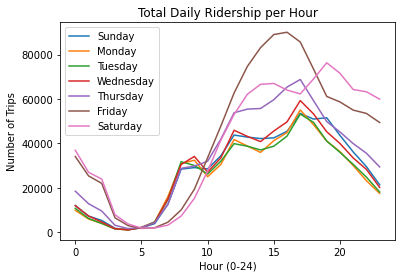

In [16]:
# Create a DataFrame grouped by Hour and day of week
scoots_hour_day = scooters.groupby(by=['Hour', 'Day of Week']).count()

# Create a pivot table with the days of the week as columns. Use the Device ID to maintain the count.
scoots_hour_day = scoots_hour_day.reset_index().pivot(index='Hour', columns='Day of Week', values='Device ID')

# Rename the columns to the verbal days of the week
scoots_hour_day.columns = days

# Plot the result
scoots_hour_day.plot()

plt.title('Total Daily Ridership per Hour')
plt.xlabel('Hour (0-24)')
plt.ylabel('Number of Trips')
plt.show()
plt.close() 
    

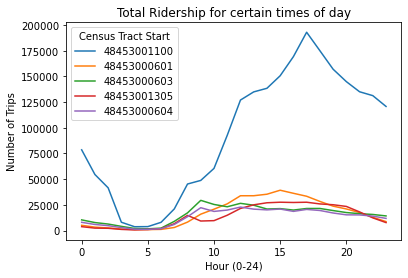

In [17]:
# Create a DataFrame grouped by Hour and day of week
scoots_hour_cts = scooters.groupby(by=['Hour', 'Census Tract Start']).count()

# Create a pivot table with the days of the week as columns. Use the Device ID to maintain the count.
scoots_hour_cts = scoots_hour_cts.reset_index().pivot(index='Hour', columns='Census Tract Start', values='Device ID')

# Plot the result for the top 5 census tracts
scoots_hour_cts[list(census_comp.head(5).index)].plot()

plt.title('Total Ridership for certain times of day')
plt.xlabel('Hour (0-24)')
plt.ylabel('Number of Trips')
plt.show()
plt.close() 

## 11. What does movement between Census Tracts look like?

In [18]:
# Import centroids file, which I created from US census bureau's TIGER shapefile using QGIS.
centroids_dtypes = {'CTIDFP00': str}
centroids = pd.read_csv('ct data/centroids.csv', dtype=centroids_dtypes)
centroids.head()

# Drop unneeded columns
centroids = centroids.drop(['STATEFP00', 'COUNTYFP00', 'TRACTCE00', 'NAME00', 'NAMELSAD00', 
                            'MTFCC00', 'FUNCSTAT00', 'ALAND00', 'AWATER00'],
                          axis=1)

# Perform 1st join for start locations.  Left join because we want to keep all values in scooters 
scooters = pd.merge(scooters, centroids, how='left', left_on='Census Tract Start', 
                    right_on='CTIDFP00', copy=False)
scooters = scooters.drop('CTIDFP00', axis=1)

# Rename columns
scooters = scooters.rename(columns={'INTPTLAT00': 'start_lat', 'INTPTLON00': 'start_long'}, 
                           copy=False)


# Perform 2nd join for end locations. Also a left join
scooters = pd.merge(scooters, centroids, how='left', left_on='Census Tract End', 
                    right_on='CTIDFP00', copy=False)
scooters = scooters.drop('CTIDFP00', axis=1)

# Rename columns
scooters = scooters.rename(columns={'INTPTLAT00': 'end_lat', 'INTPTLON00': 'end_long'}, 
                           copy=False)

In [19]:
# Create a function that will plot trips from each census tract
def plot_trips(df, census_tract, bbox, color='b', vmin_trips=0, vmax_quantile=0.75, linewidth=3):

    # Create a dataframe from the desired census tract
    lines = df.loc[df['Census Tract Start'] == census_tract][['Census Tract Start', 'Census Tract End', 'start_lat', 'start_long', 
                  'end_lat', 'end_long']].copy()

    # Count the census tract ends
    line_vals = pd.DataFrame(lines['Census Tract End'].value_counts())
    
    # Rename the values columns
    line_vals.columns = ['CT End Count']

    # Merge the line vals with 
    line_intensity = pd.merge(pd.DataFrame(line_vals), lines, how='inner', left_index=True, right_on='Census Tract End')

    # Drop duplicates
    line_intensity = line_intensity.drop_duplicates()
    
    # Convert the lat/long data in the dataframe to linestrings
    line_intensity['geometry'] = line_intensity.apply(lambda x: LineString([(x['start_long'], x['start_lat']) , 
                                                      (x['end_long'], x['end_lat'])]), axis = 1)

    # Create the geopandas geodataframe.
    line_intensity = gpd.GeoDataFrame(line_intensity, geometry='geometry')
    
    # Plot the base map
    ax_trips = map_df.plot(color='0.9', figsize=(15, 15), edgecolor='0')

    # Set the extents using bbox from section 4
    plt.xlim(bbox[0], bbox[1])
    plt.ylim(bbox[2], bbox[3])

    # Resort so that smallest CT End Counts are plotted first
    line_intensity = line_intensity.sort_values(by='CT End Count')
    
    # Set vmax to limit the max color to the vmax_quantile 
    vmax_trips = line_intensity['CT End Count'].quantile(vmax_quantile)
  
    # Plot the lines
    line_intensity.plot(column='CT End Count', 
                        cmap=color, 
                        linewidth=linewidth, 
                        ax = ax_trips, 
                        vmin = vmin_trips, 
                        vmax = vmax_trips)
    
    # Add a color bar
    sm_trips = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin_trips, vmax=vmax_trips))
    plt.colorbar(sm_trips, fraction=0.015, aspect=50, 
                 label='Number of trips (maximum includes values shown and above)')

    # Add a title and show
    plt.title('Trips originating in' + census_tract)
    
    # Remove axes
    plt.axis('off')
    

    plt.show()
    plt.close()


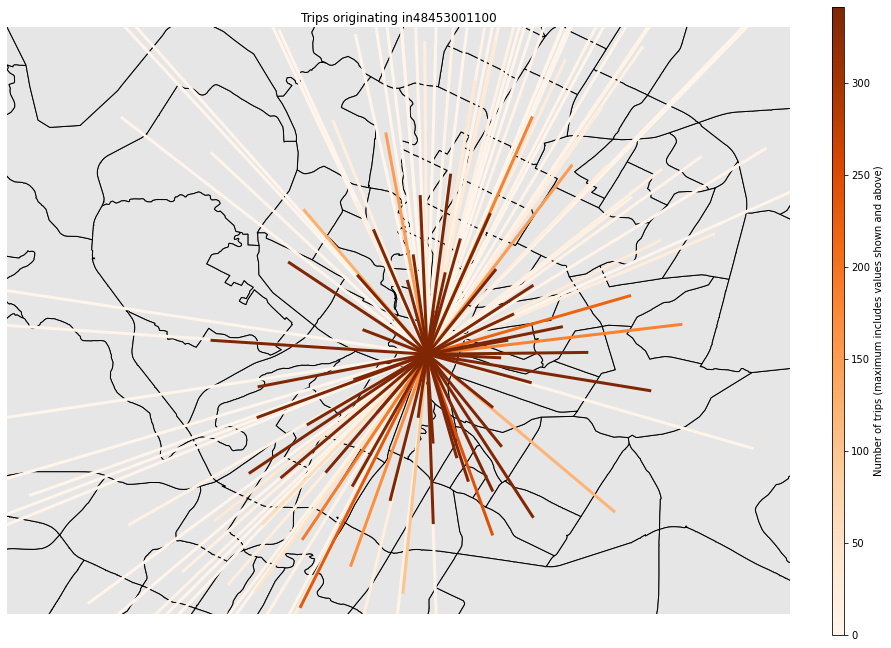

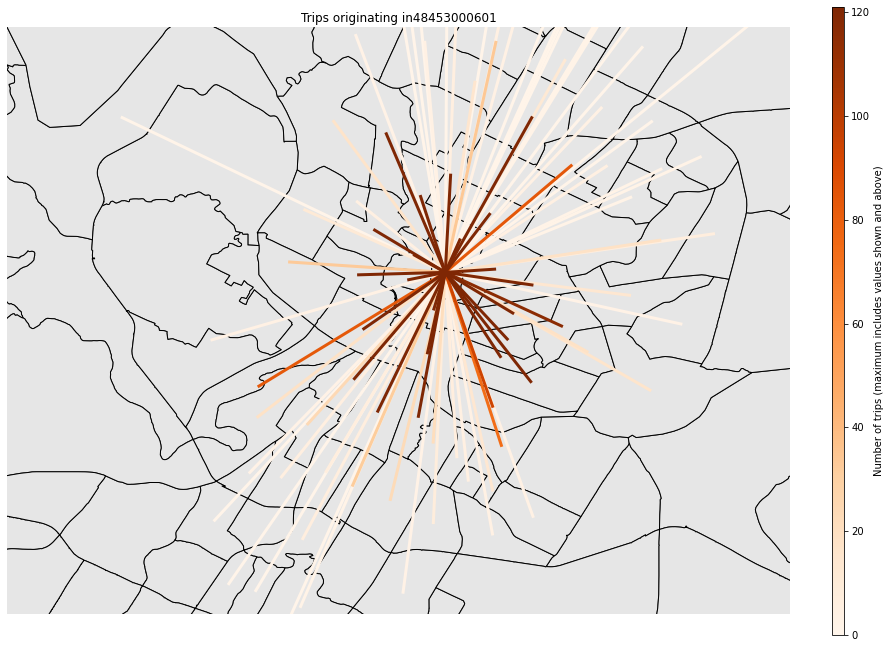

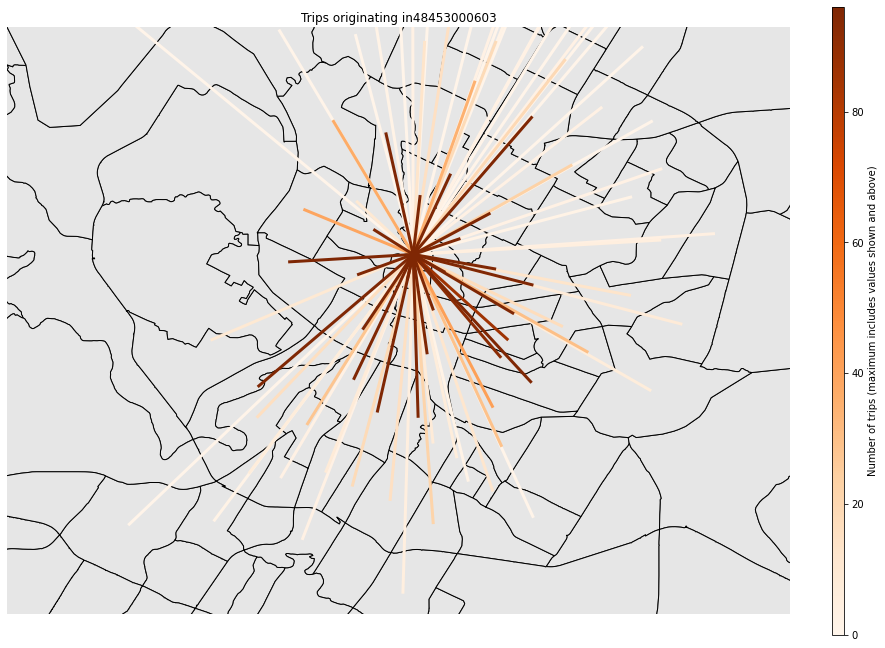

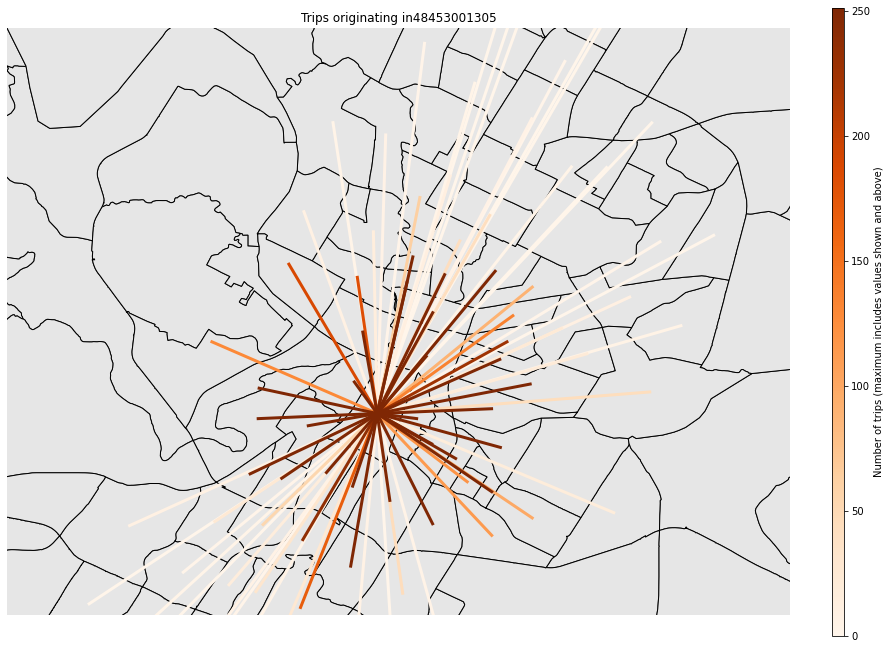

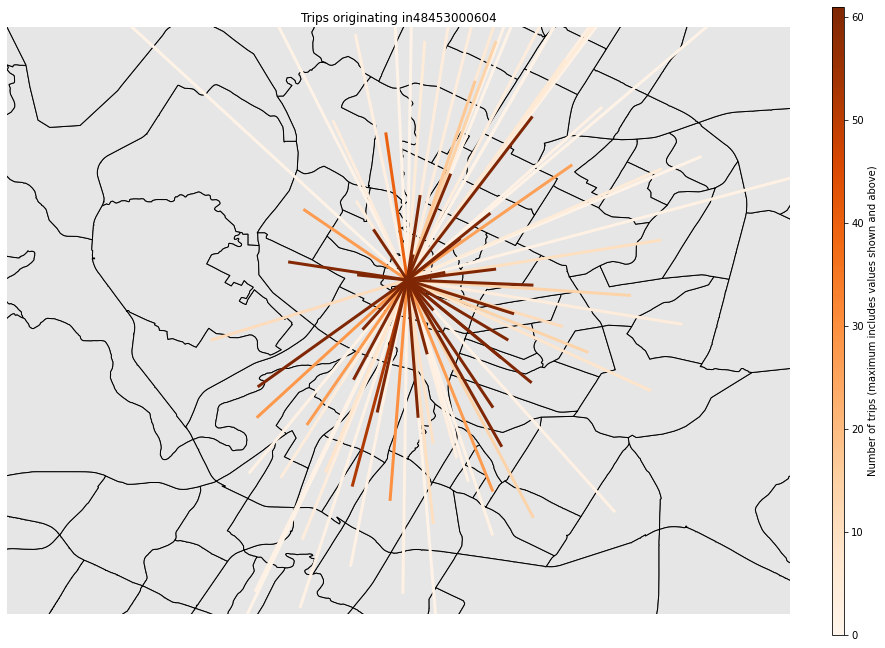

In [20]:
# Create plots of the top 4 census tracts
for i, val in census_starts.head().iterrows():
     plot_trips(scooters, i, bbox=bbox, color='Oranges')

In [21]:
scooters.shape

(5425258, 21)